# Practise - Topic Network Analysis in Online Communities

## Import libraries

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

import re
import spacy
from nltk.corpus import stopwords

import networkx as nx
from itertools import combinations

import dataframe_image as dfi

from ipynb.fs.full.helper_functions import *

## Step 1: Data Processing

In [2]:
# Initialise variables
num_of_chats = 8
delta = np.timedelta64(1,'D')

post_paths = [None] * num_of_chats
comment_paths = [None] * num_of_chats
df_posts = [None] * num_of_chats
df_comments = [None] * num_of_chats
df_preprocessed_list = [None] * num_of_chats
timespan_list = [None] * num_of_chats
chat_doc_list = [None] * num_of_chats
chat_doc_list_ready = [None] * num_of_chats
chat_numOfSamples_list = [None] * num_of_chats
chat_id2word = [None] * num_of_chats
chat_corpus = [None] * num_of_chats

In [3]:
# Define file paths

'''Ethereum'''
post_paths[0] = '../data/ethereum_posts_reddit.csv'
comment_paths[0] = '../data/ethereum_comments_reddit.csv'

'''Litecoin'''
post_paths[1] = '../data/litecoin_posts_reddit.csv'
comment_paths[1] = '../data/litecoin_comments_reddit.csv'

'''Dogecoin'''
post_paths[2] = '../data/dogecoin_posts_reddit.csv'
comment_paths[2] = '../data/dogecoin_comments_reddit.csv'

'''NEM'''
post_paths[3] = '../data/nem_posts_reddit.csv'
comment_paths[3] = '../data/nem_comments_reddit.csv'

'''Ripple'''
post_paths[4] = '../data/ripple_posts_reddit.csv'
comment_paths[4] = '../data/ripple_comments_reddit.csv'

'''Binance'''
post_paths[5] = '../data/binance_posts_reddit.csv'
comment_paths[5] = '../data/binance_comments_reddit.csv'

'''Iota'''
post_paths[6] = '../data/iota_posts_reddit.csv'
comment_paths[6] = '../data/iota_comments_reddit.csv'

'''Cardano'''
post_paths[7] = '../data/cardano_posts_reddit.csv'
comment_paths[7] = '../data/cardano_comments_reddit.csv'

In [4]:
# Read data from csv files
for i in range(num_of_chats):
    df_posts[i] = pd.read_csv(post_paths[i])
    df_comments[i] = pd.read_csv(comment_paths[i])

In [5]:
for i in range(num_of_chats):
    df_preprocessed_list[i] = preprocess_data(df_posts[i], df_comments[i])
    timespan_list[i] = get_timespan(df_preprocessed_list[i])
    
if all(timespan == timespan_list[0] for timespan in timespan_list):
    timespan = timespan_list[0]
else:
    raise Exception("ERROR: Please make sure that all datasets have the same time span!")
    
num_of_timeframes, timeframe_list = get_timeframes(timespan, delta)
formatted_timeframes_str = get_formatted_timeframes_str(timeframe_list)

In [6]:
for i in range(num_of_chats):
    # Split document based on time frame
    chat_doc_list[i] = split_doc_by_timeframe(timeframe_list, df_preprocessed_list[i])
    # Process data (tokenisation, building N-grams and lemmatisation)
    chat_doc_list_ready[i] = [process_words(doc) for doc in chat_doc_list[i]]
    # Calculatet the number of samples per timeframe for each chat
    chat_numOfSamples_list[i] = [len(doc) for doc in chat_doc_list[i]]
    # Create the Dictionary and Corpus for Topic Modeling
    chat_id2word[i], chat_corpus[i] = convert_to_bagOfWords(chat_doc_list_ready[i])

In [7]:
df_chat_processed = get_df_processed(formatted_timeframes_str, chat_numOfSamples_list[0], chat_doc_list_ready[0])
df_chat_processed.head(10)

,Timeframe interval,Sample size,Document
Timeframe 1,[ 2021-01-01 - 2021-01-02 ),499,"[[compute, space, private, company, university..."
Timeframe 2,[ 2021-01-02 - 2021-01-03 ),502,"[[cost, approximately], [thesis, college, issu..."
Timeframe 3,[ 2021-01-03 - 2021-01-04 ),1095,"[[fine, food, smart, enough, articulate, lack,..."
Timeframe 4,[ 2021-01-04 - 2021-01-05 ),782,"[[offline, mew, wallet, hardware, wallet, offl..."
Timeframe 5,[ 2021-01-05 - 2021-01-06 ),674,"[[exactly, tether, shady, peg, reason], [newbi..."
Timeframe 6,[ 2021-01-06 - 2021-01-07 ),897,"[[shitcoin], [cost, chop, tree, temperature, r..."
Timeframe 7,[ 2021-01-07 - 2021-01-08 ),1154,"[[consistent, prove, scammer, scam, idiot, alt..."
Timeframe 8,[ 2021-01-08 - 2021-01-09 ),817,"[[age, well], [create, watchface, wear, device..."
Timeframe 9,[ 2021-01-09 - 2021-01-10 ),656,"[[forget, around, week, stake, work], [ethereu..."
Timeframe 10,[ 2021-01-10 - 2021-01-11 ),986,"[[crypto, reddit, almost, overrun, leftist, to..."


## Step 2: Topic Modelling

In [8]:
# Initialise variables
num_of_topics = 10
num_topics_list = [num_of_topics] * num_of_timeframes
chat_lda_model_list = [None] * num_of_chats
chats_topics_list = [None] * num_of_chats

In [9]:
for i in range(num_of_chats):
    chat_lda_model_list[i] = get_lda_models(chat_corpus[i], chat_id2word[i], num_topics_list)
    chats_topics_list[i] = get_topics(chat_lda_model_list[i], num_topics_list)

In [10]:
df_chat_topics = get_df_topics(chats_topics_list[0])
df_chat_topics.head()

,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8,Topic 9,Topic 10
TF 1,buy,ethereum,good,nft,option,price,time,wallet,-,-
TF 2,ethereum,fee,get,wallet,-,-,-,-,-,-
TF 3,bitcoin,buy,ethereum,fee,get,price,read,wallet,-,-
TF 4,ethereum,get,time,transaction,upgrade,wallet,-,-,-,-
TF 5,bitcoin,eth,ethereum,fee,good,wallet,well,-,-,-


## Step 3: Network Analysis

In [11]:
# Initialise variables
G_list = [None] * num_of_timeframes
node_pair_list = [None] * num_of_timeframes
dates = np.arange('2021-01-01', '2021-02-28', dtype='datetime64[D]')

# Re-scaled lower bound & upper bound
new_min = 0.8
new_max = 4

In [12]:
for i in range(num_of_timeframes):
    topics_list = [None] * num_of_chats
    for j in range(num_of_chats):
        topics_list[j] = chats_topics_list[j][i]
    G_list[i], node_pair_list[i] = get_network_graph(topics_list)

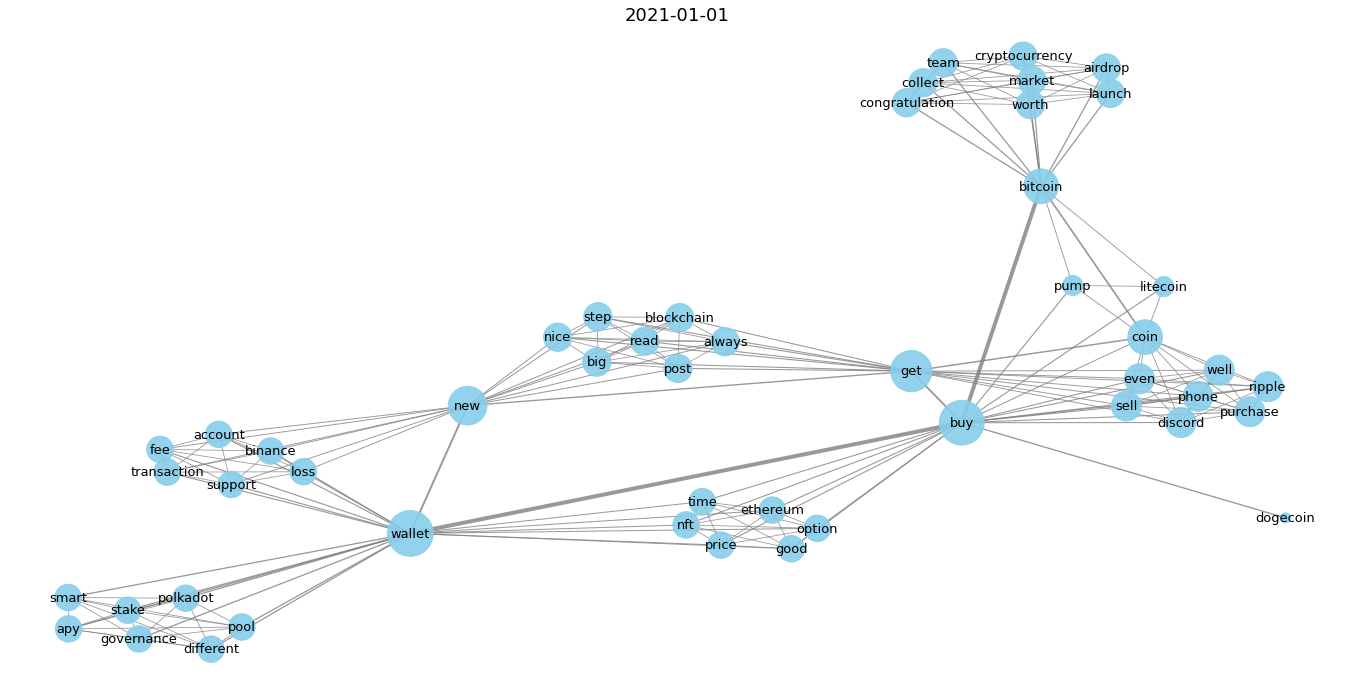

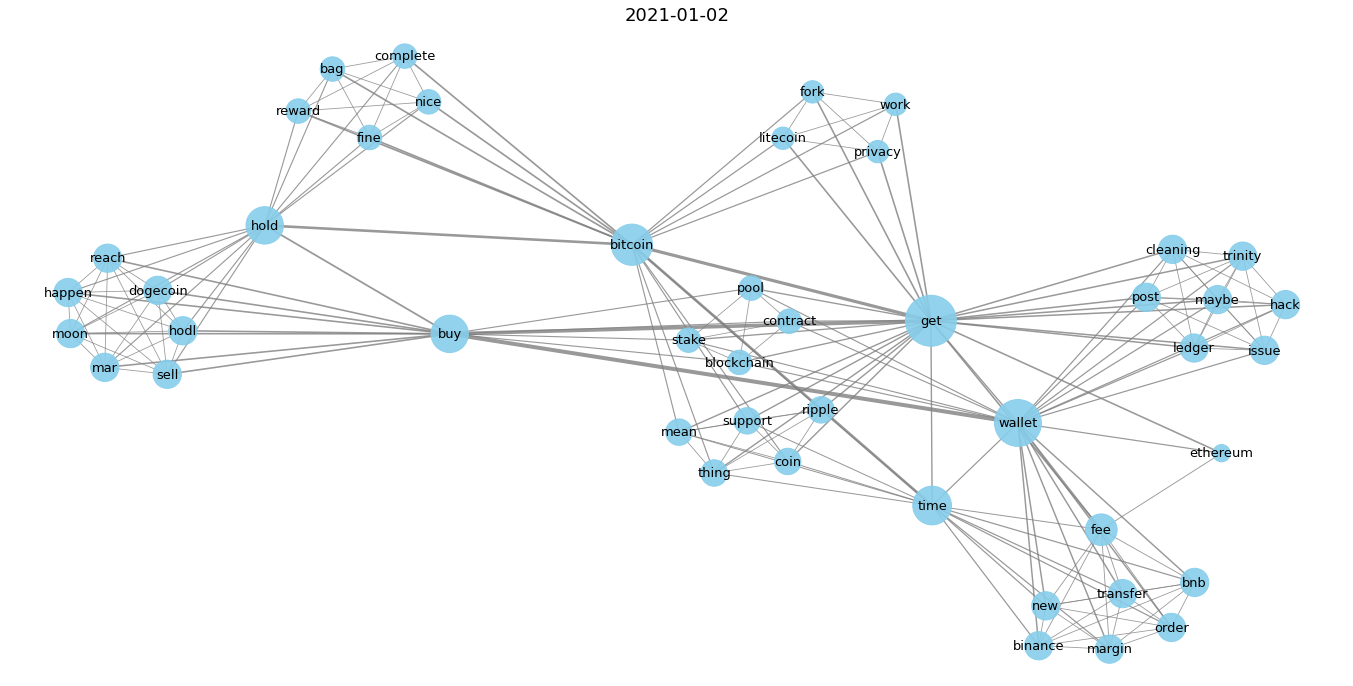

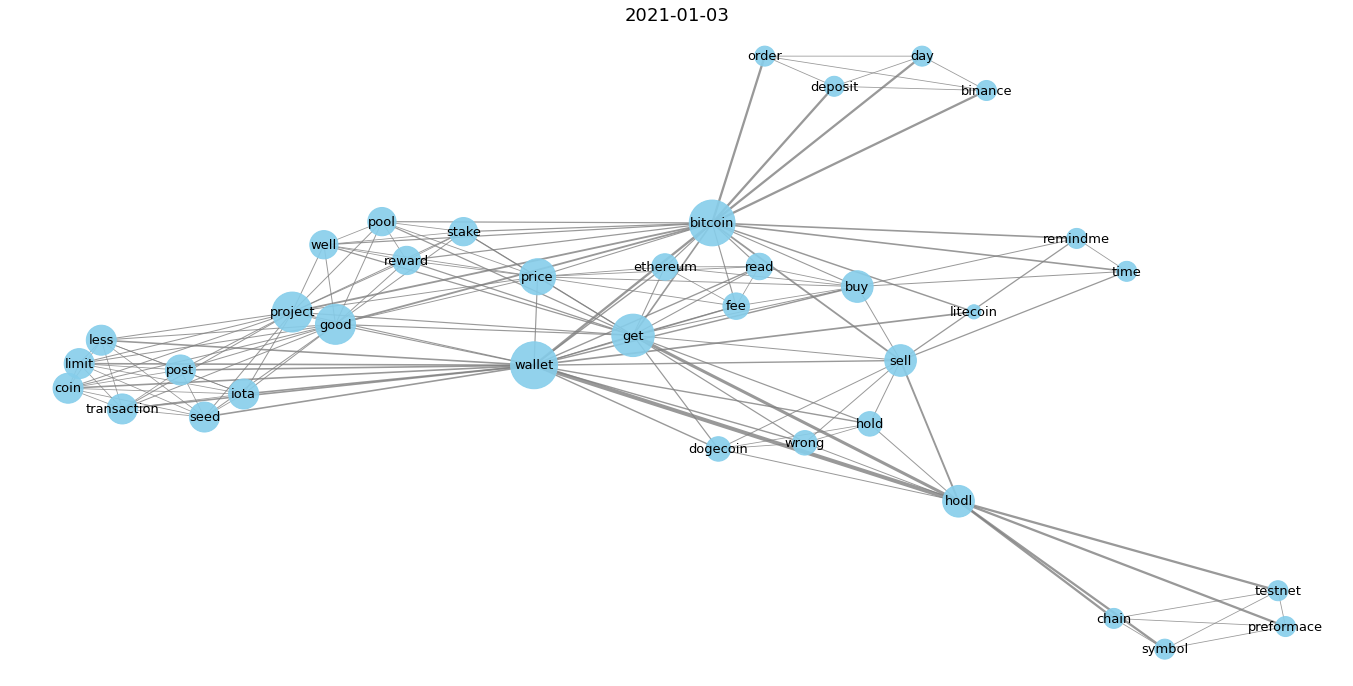

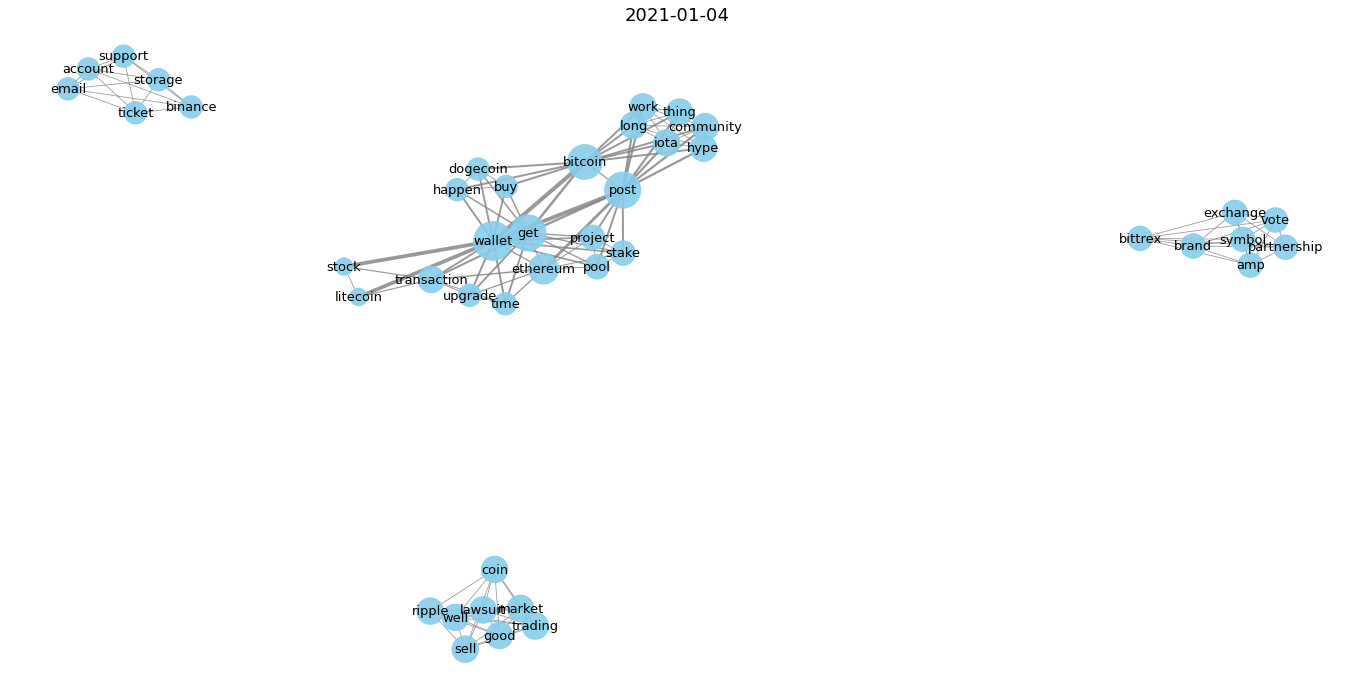

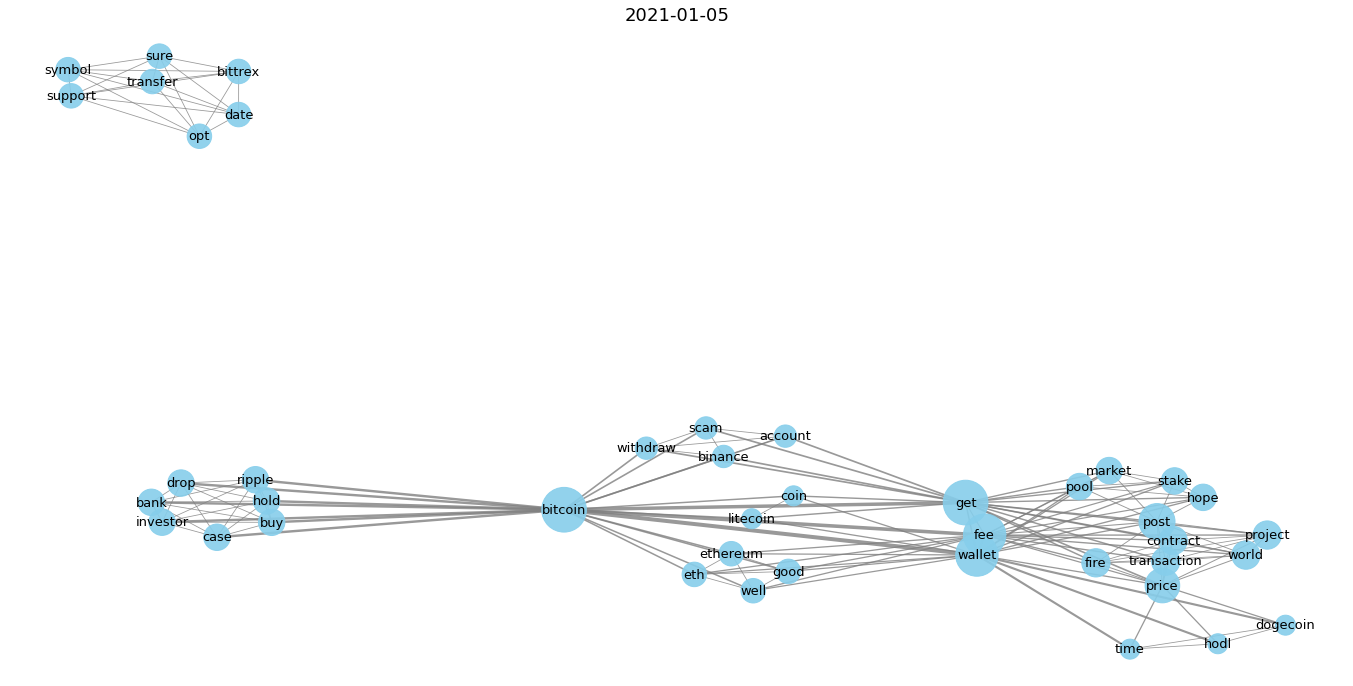

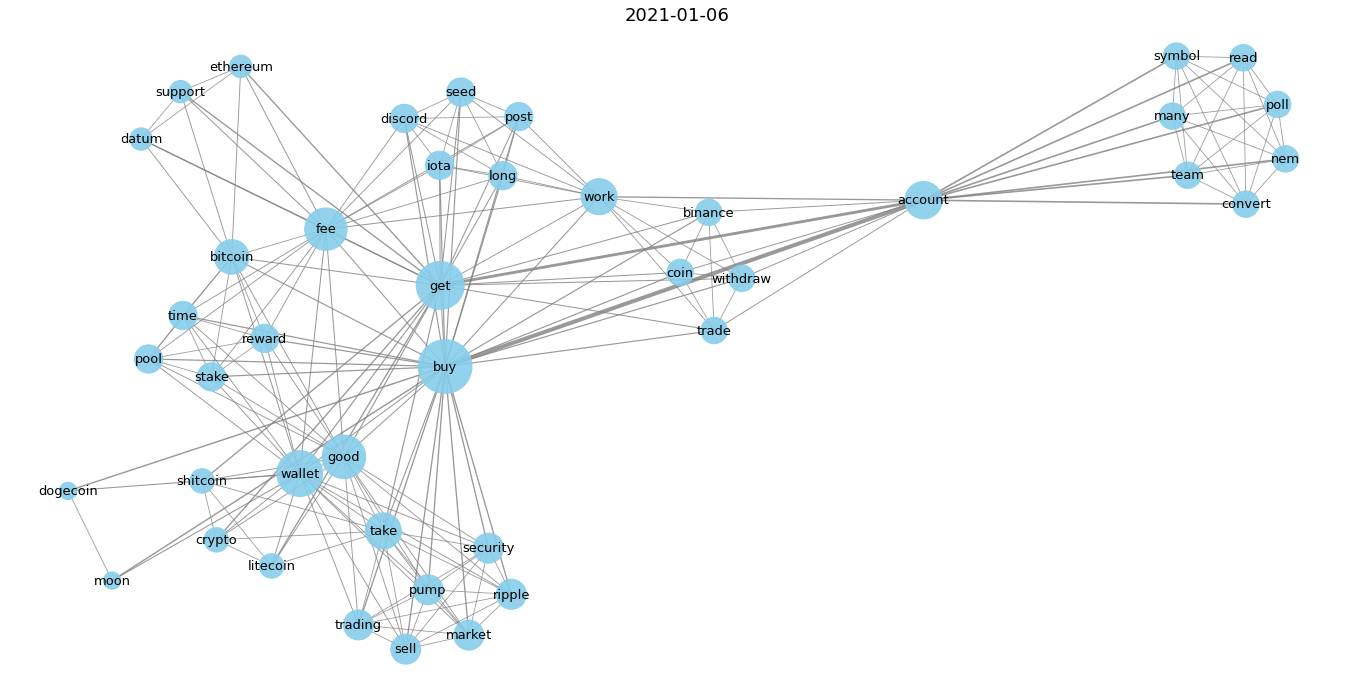

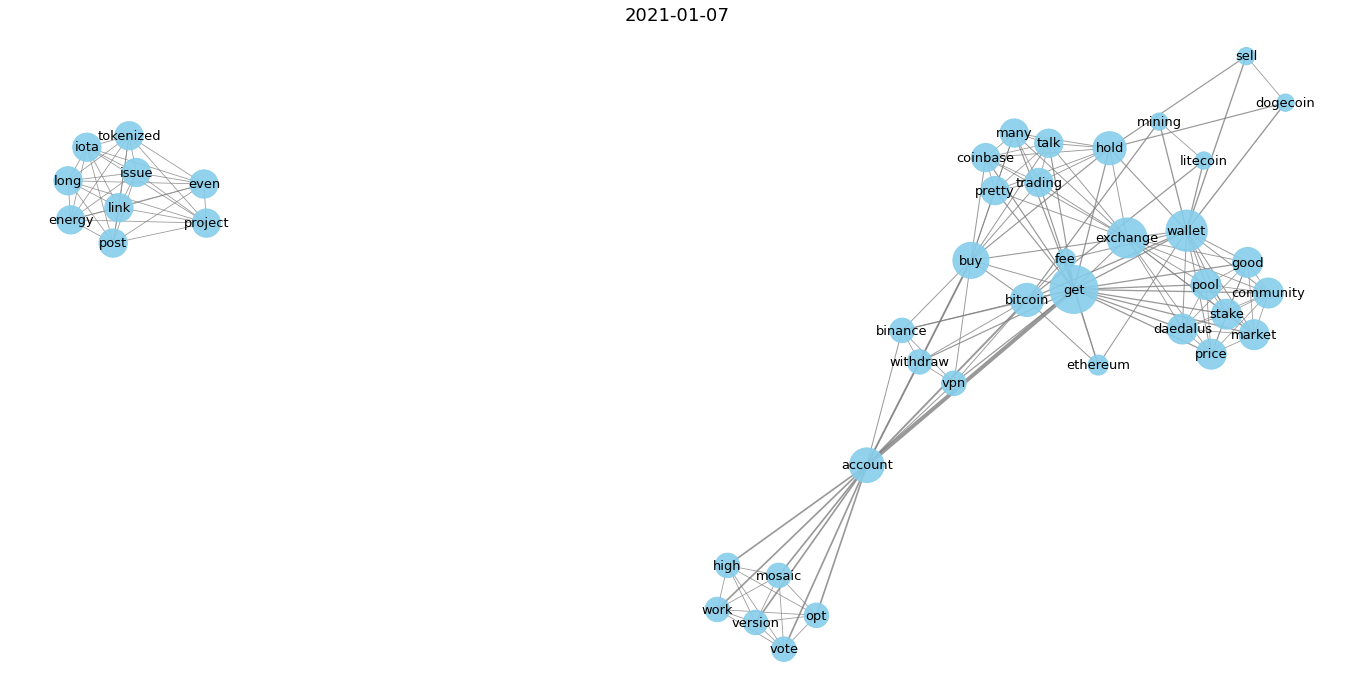

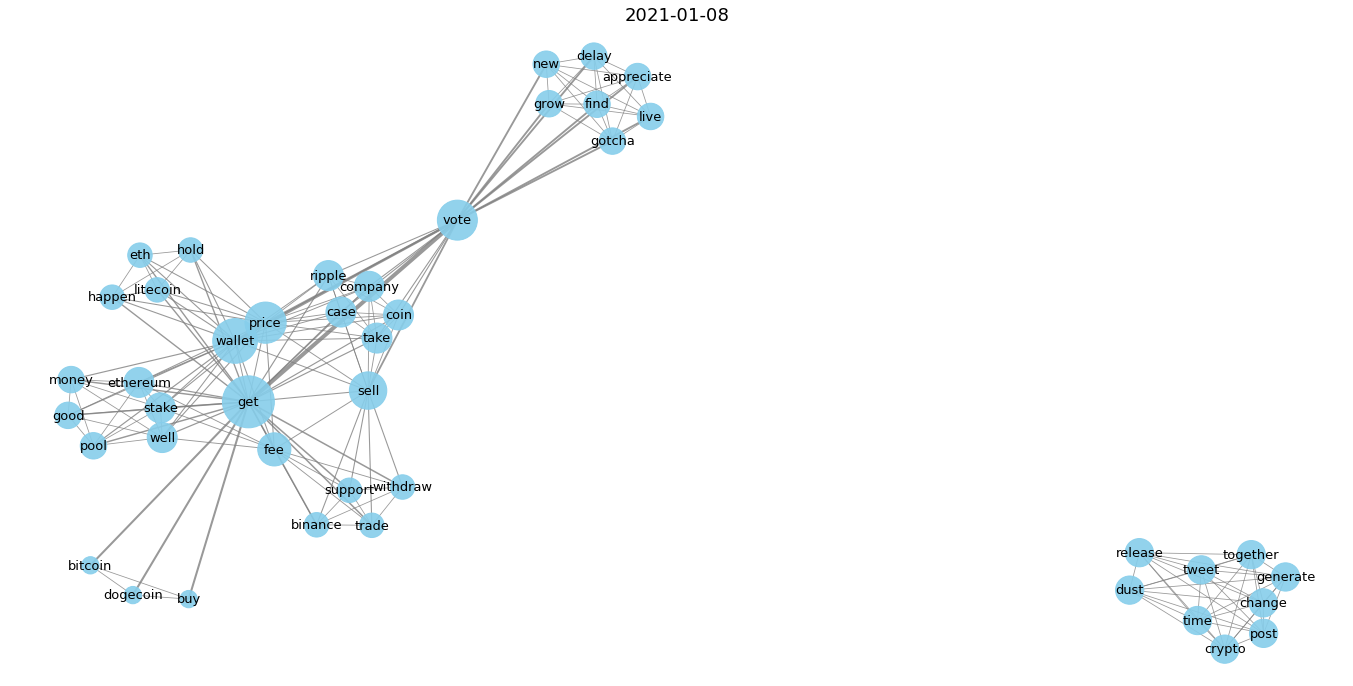

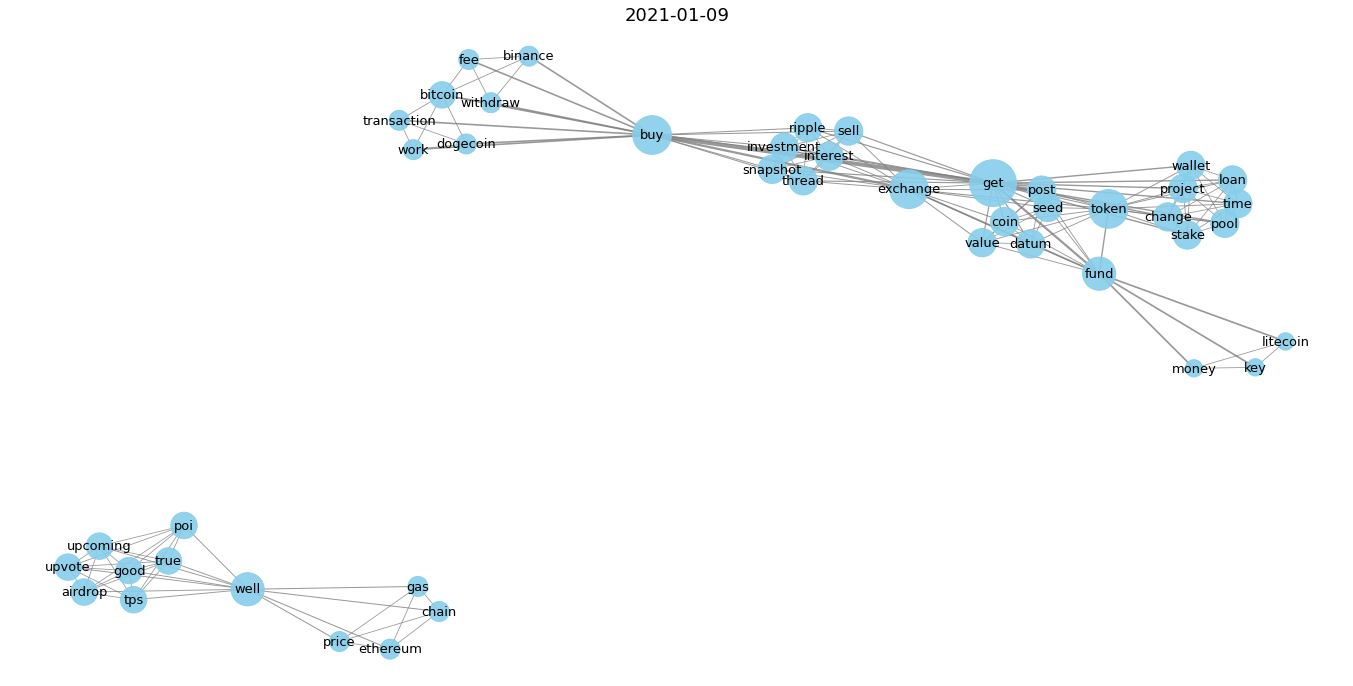

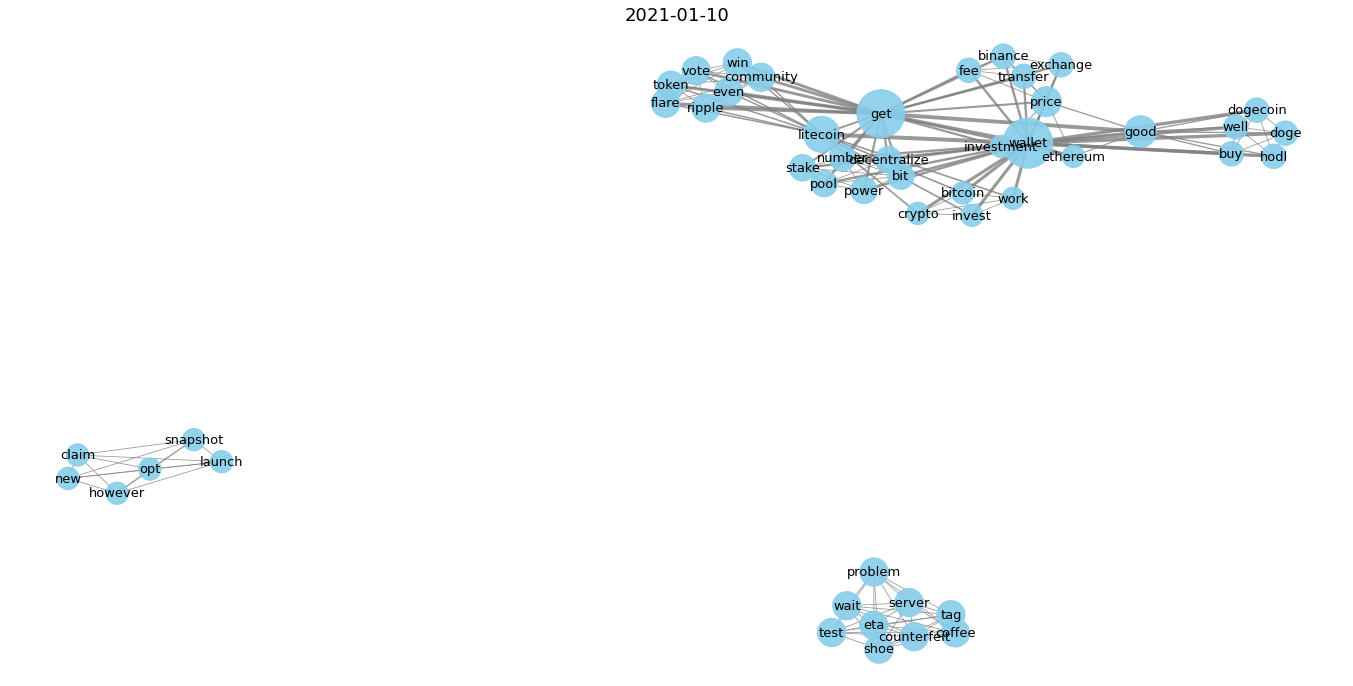

In [13]:
for i in range(10):
    fig = plt.figure(i, figsize=(24, 12))
    plt.axis('off')
    plt.title(dates[i], fontsize = 18)
    pos = nx.spring_layout(G_list[i], k=0.3)
    d = dict(G_list[i].degree)

    widths = nx.get_edge_attributes(G_list[i], 'betweenness')
    
    values = widths.values()
    w_min = min(values)
    w_max = max(values)
    
    if w_min != w_max:
        widths = {key: ((v - w_min) / (w_max - w_min)) * (new_max - new_min) + new_min  for (key, v) in widths.items()}

    nx.draw_networkx_nodes(G_list[i], pos = pos, node_size =[v * 100 for v in d.values()], with_labels=True, node_color = 'skyblue', alpha = 0.9)
    nx.draw_networkx_edges(G_list[i], pos = pos, width = list(widths.values()), edge_color = 'grey', alpha = 0.8)
    nx.draw_networkx_labels(G_list[i], pos = pos,font_size = 13)
    
    if i < 5:
        plt.savefig('../image_practise/Network_' + str(dates[i]), dpi = 800)

### • Centrality measure

#### < Degree centrality >
The degree of a node is the number of other nodes to which it is connected

In [14]:
dc = []
for i in range(num_of_timeframes):
    degree_centrality = nx.degree_centrality(G_list[i])
    dc = dc + sorted(degree_centrality.items(), key=lambda x:x[1], reverse=True)[:3]
    
dc = np.reshape(dc, (58, 6))
df_dc = pd.DataFrame(dc)
df_dc.index = dates
for i in range(1, 6, 2):
    df_dc[i] = df_dc[i].astype(float).round(2)

df_dc.rename(columns={0: 'Top 1', 1: 'Degree centrality 1',
                      2: 'Top 2', 3: 'Degree centrality 2',
                      4: 'Top 3', 5: 'Degree centrality 3',}, inplace=True)
df_dc.head(10)

,Top 1,Degree centrality 1,Top 2,Degree centrality 2,Top 3,Degree centrality 3
2021-01-01,wallet,0.43,buy,0.41,get,0.35
2021-01-02,get,0.58,wallet,0.49,bitcoin,0.38
2021-01-03,wallet,0.61,bitcoin,0.58,get,0.50
2021-01-04,wallet,0.36,post,0.31,get,0.31
2021-01-05,get,0.49,bitcoin,0.49,fee,0.44
2021-01-06,buy,0.69,get,0.55,wallet,0.50
2021-01-07,get,0.55,wallet,0.40,exchange,0.38
2021-01-08,get,0.63,wallet,0.47,price,0.40
2021-01-09,get,0.50,exchange,0.34,token,0.34
2021-01-10,wallet,0.53,get,0.49,litecoin,0.28


In [15]:
dfi.export(df_dc.head(), '../image_practise/degree_centrality.png')

In [16]:
dc_top3_centralities = list(df_dc['Top 1']) + list(df_dc['Top 2']) + list(df_dc['Top 3'])
df_dc_top3_centralities = pd.DataFrame(dc_top3_centralities)
df_dc_value_counts = df_dc_top3_centralities[0].value_counts().rename_axis('Topics').reset_index(name='Counts')
df_dc_value_counts['Percentage'] = df_dc_value_counts['Counts'].div(len(dc_top3_centralities)).apply(lambda x: format(x, '.1%'))
df_dc_value_counts.head(10)

,Topics,Counts,Percentage
0,get,43,24.7%
1,wallet,36,20.7%
2,buy,29,16.7%
3,bitcoin,15,8.6%
4,price,6,3.4%
5,post,5,2.9%
6,coin,5,2.9%
7,exchange,4,2.3%
8,fee,4,2.3%
9,stake,4,2.3%


In [17]:
dfi.export(df_dc_value_counts.head(), '../image_practise/value_count_degree_centrality.png')

==============================================================================================================================================

#### < Betweenness centrality >
Betweenness centrality quantifies the number of times a node acts as a bridge(or "broker") along the shortest path between two other nodes.

In [18]:
bc = []
for i in range(num_of_timeframes):
    betweenness_centrality = nx.betweenness_centrality(G_list[i])
    bc = bc + sorted(betweenness_centrality.items(), key=lambda x:x[1], reverse=True)[:3]
    
bc = np.reshape(bc, (58, 6))
df_bc = pd.DataFrame(bc)
df_bc.index = dates
for i in range(1, 6, 2):
    df_bc[i] = df_bc[i].astype(float).round(2)

df_bc.rename(columns={0: 'Top 1', 1: 'Betweenness centrality 1',
                      2: 'Top 2', 3: 'Betweenness centrality 2',
                      4: 'Top 3', 5: 'Betweenness centrality 3',}, inplace=True)
df_bc.head(10)

,Top 1,Betweenness centrality 1,Top 2,Betweenness centrality 2,Top 3,Betweenness centrality 3
2021-01-01,buy,0.45,wallet,0.39,bitcoin,0.28
2021-01-02,get,0.34,bitcoin,0.21,buy,0.21
2021-01-03,wallet,0.28,bitcoin,0.28,hodl,0.20
2021-01-04,wallet,0.07,post,0.06,bitcoin,0.04
2021-01-05,bitcoin,0.27,get,0.15,wallet,0.13
2021-01-06,buy,0.35,account,0.28,get,0.21
2021-01-07,get,0.22,account,0.19,wallet,0.09
2021-01-08,get,0.25,vote,0.21,wallet,0.08
2021-01-09,get,0.21,buy,0.19,fund,0.09
2021-01-10,wallet,0.19,get,0.15,litecoin,0.04


In [19]:
dfi.export(df_bc.head(), '../image_practise/betweenness_centrality.png')

In [20]:
bc_top3_centralities = list(df_bc['Top 1']) + list(df_bc['Top 2']) + list(df_bc['Top 3'])
df_bc_top3_centralities = pd.DataFrame(bc_top3_centralities)
df_bc_value_counts = df_bc_top3_centralities[0].value_counts().rename_axis('Topics').reset_index(name='Counts')
df_bc_value_counts['Percentage'] = df_bc_value_counts['Counts'].div(len(bc_top3_centralities)).apply(lambda x: format(x, '.1%'))
df_bc_value_counts.head(10)

,Topics,Counts,Percentage
0,get,45,25.9%
1,wallet,36,20.7%
2,buy,27,15.5%
3,bitcoin,17,9.8%
4,coin,6,3.4%
5,price,5,2.9%
6,fee,4,2.3%
7,exchange,3,1.7%
8,post,3,1.7%
9,good,3,1.7%


In [21]:
dfi.export(df_bc_value_counts.head(), '../image_practise/value_count_betweenness_centrality.png')

### • Changes in topology

In [22]:
union_topics_list = [None] * num_of_timeframes
for i in range(num_of_timeframes):
    tf_chat_topics_list = []
    for chat_topics_list in chats_topics_list:
        tf_chat_topics_list.append(chat_topics_list[i])
    union_topics_list[i] = list(set().union(*tf_chat_topics_list))

In [23]:
num_topics = [len(topics) for topics in union_topics_list]
num_new_topics = [None] * num_of_timeframes
num_preexisting_topics = [None] * num_of_timeframes
num_disappearing_topics = [None] * num_of_timeframes
perc_new_topics = [None] * num_of_timeframes
perc_preexisting_topics = [None] * num_of_timeframes


for i in range(num_of_timeframes-1):
    num_new_topics[i+1] = len(list(set(union_topics_list[i+1]) - set(union_topics_list[i])))
    num_preexisting_topics[i+1] = len(list(set(union_topics_list[i+1]) & set(union_topics_list[i])))
    num_disappearing_topics[i+1] = len(list(set(union_topics_list[i]) - set(union_topics_list[i+1])))
    perc_new_topics[i+1] = num_new_topics[i+1] / num_topics[i-1]
    perc_preexisting_topics[i+1] = num_preexisting_topics[i+1] / num_topics[i-1]

In [24]:
data = {'No. of topics': num_topics,
        'No. of new topics': num_new_topics,
        '% new topics': perc_new_topics,
        'No. of pre-existing topics': num_preexisting_topics,
        '% pre-existing topics': perc_preexisting_topics,
        'No. of disappearing topics': num_disappearing_topics}


df_topology = pd.DataFrame(data)
df_topology.index = dates #['TF ' + str(i+1) for i in range(n)]
df_topology = df_topology.fillna(0)

df_topology['No. of new topics']= df_topology['No. of new topics'].astype(int)
df_topology['No. of pre-existing topics']= df_topology['No. of pre-existing topics'].astype(int)
df_topology['No. of disappearing topics']= df_topology['No. of disappearing topics'].astype(int)

df_topology['% new topics']= df_topology['% new topics'].apply(lambda x: float(format(x*100, '.1f')))
df_topology['% pre-existing topics']= df_topology['% pre-existing topics'].apply(lambda x: float(format(x*100, '.1f')))

df_topology.head(10)

,No. of topics,No. of new topics,% new topics,No. of pre-existing topics,% pre-existing topics,No. of disappearing topics
2021-01-01,50,0,0.0,0,0.0,0
2021-01-02,46,26,61.9,20,47.6,30
2021-01-03,37,18,36.0,19,38.0,27
2021-01-04,43,23,50.0,20,43.5,17
2021-01-05,42,19,51.4,23,62.2,20
2021-01-06,43,22,51.2,21,48.8,21
2021-01-07,43,21,50.0,22,52.4,21
2021-01-08,44,26,60.5,18,41.9,25
2021-01-09,45,23,53.5,22,51.2,22
2021-01-10,48,28,63.6,20,45.5,25


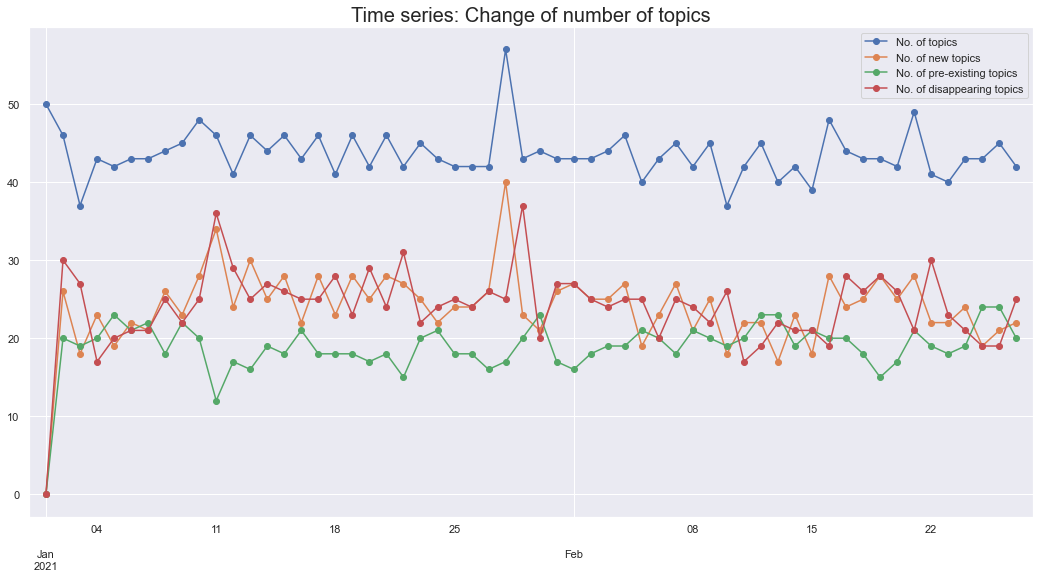

In [25]:
sns.set(rc={'figure.figsize':(18, 9)})
num_plot = ['No. of topics', 'No. of new topics','No. of pre-existing topics', 'No. of disappearing topics']
ax = df_topology[num_plot].plot(marker='o')
ax.set_title('Time series: Change of number of topics', fontsize=20)
# ax.set_ylabel('Number', fontsize=15)
ax.set_xlim('2020-12-31', '2021-02-28')
plt.savefig('../image_practise/Time series 1.png', dpi = 800)

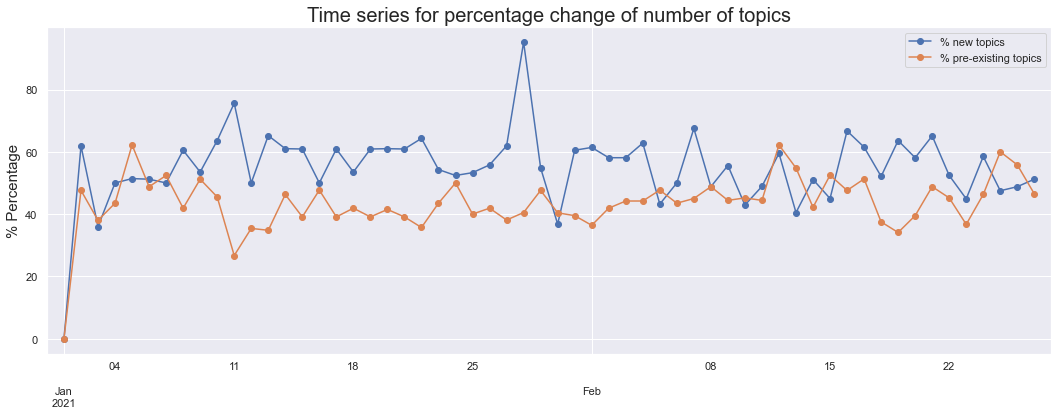

In [26]:
sns.set(rc={'figure.figsize':(18, 6)})
perc_plot = ['% new topics', '% pre-existing topics']
ax = df_topology[perc_plot].plot(marker='o')
ax.set_title('Time series for percentage change of number of topics', fontsize=20)
ax.set_ylabel('% Percentage', fontsize=15)
ax.set_xlim('2020-12-31', '2021-02-28')
plt.savefig('../image_practise/Time series 2.png', dpi = 800)